# Hiperbolica e Advecção

Nome: Yago Pereira dos Anjos Santos

## Questao 1

Considere o seguinte problema advectivo
\begin{equation*}
    \frac{\partial u}{\partial t} + 0.5\frac{\partial u}{\partial x} = 0 \text{ em }\Omega \times I
\end{equation*}

Tomando $\Omega = [0,20]$, $I=(0,15]$ e considerando condição de contorno periódica e condição inicial
\begin{equation*}
    u(x,0) = \begin{cases}
        1 & \text{ para } x\in[1,5]\\
        0 & \text{ c.c}
    \end{cases}
\end{equation*}

a) Resolva pelo método *Leapfrog* e compare com a solução exata.

b) Compare, exibindo no mesmo gráfico, a resolução deste problema pelos métodos Lax–Friedrichs, *Upwind* e a solução exata

c) Compare, exibindo no mesmo gráfico, a resolução deste problema pelos métodos Lax–Wendroff, Bear-Warming e a solução exata

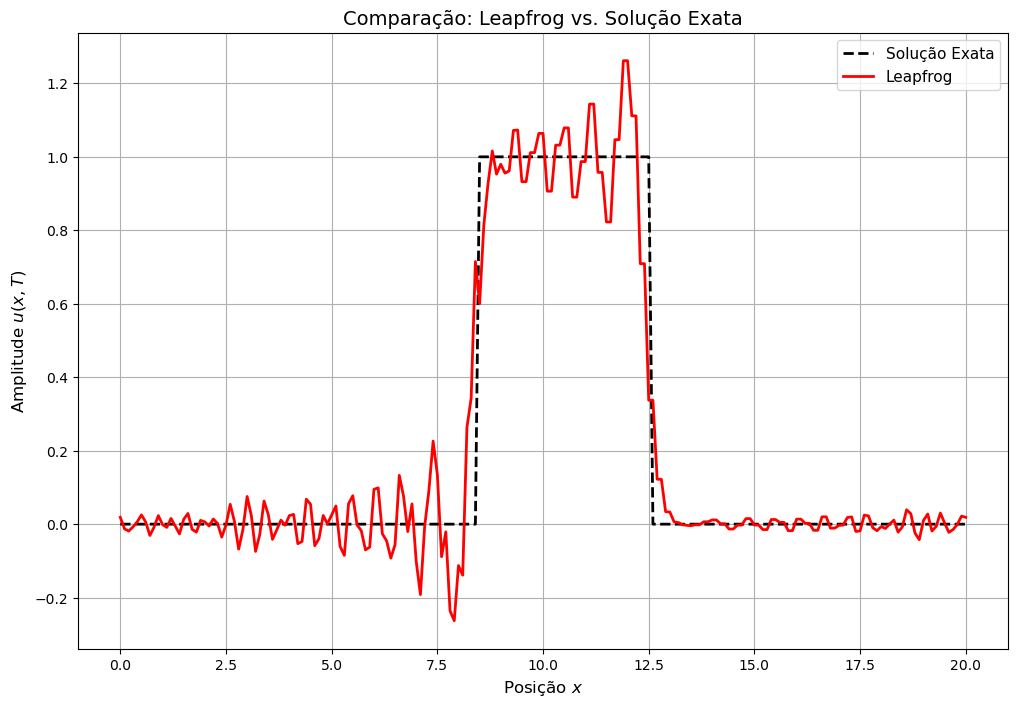

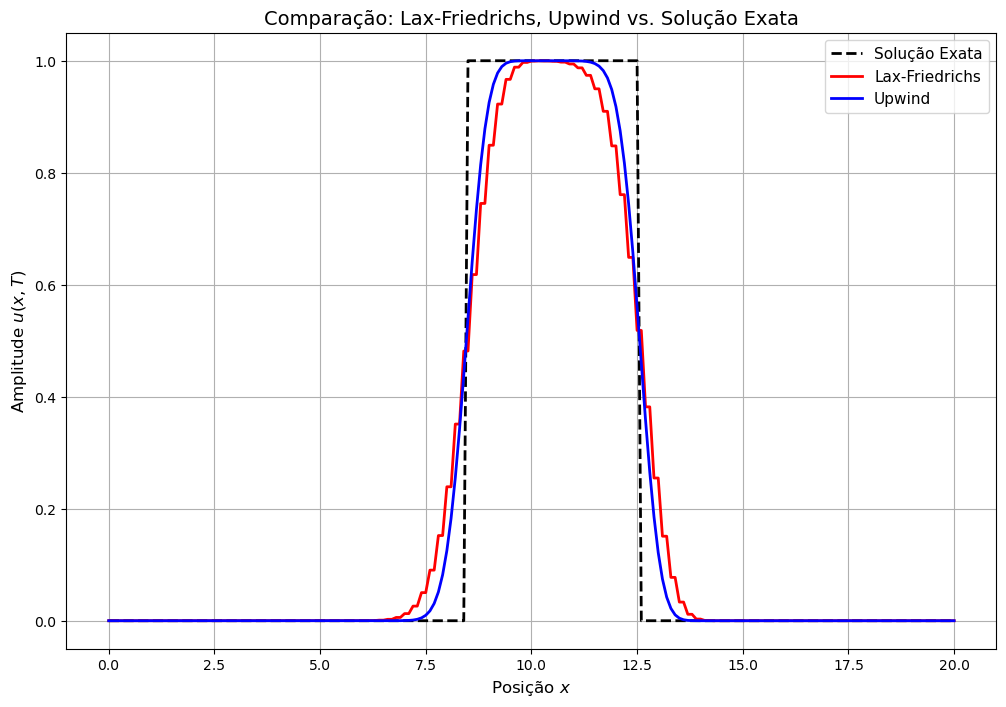

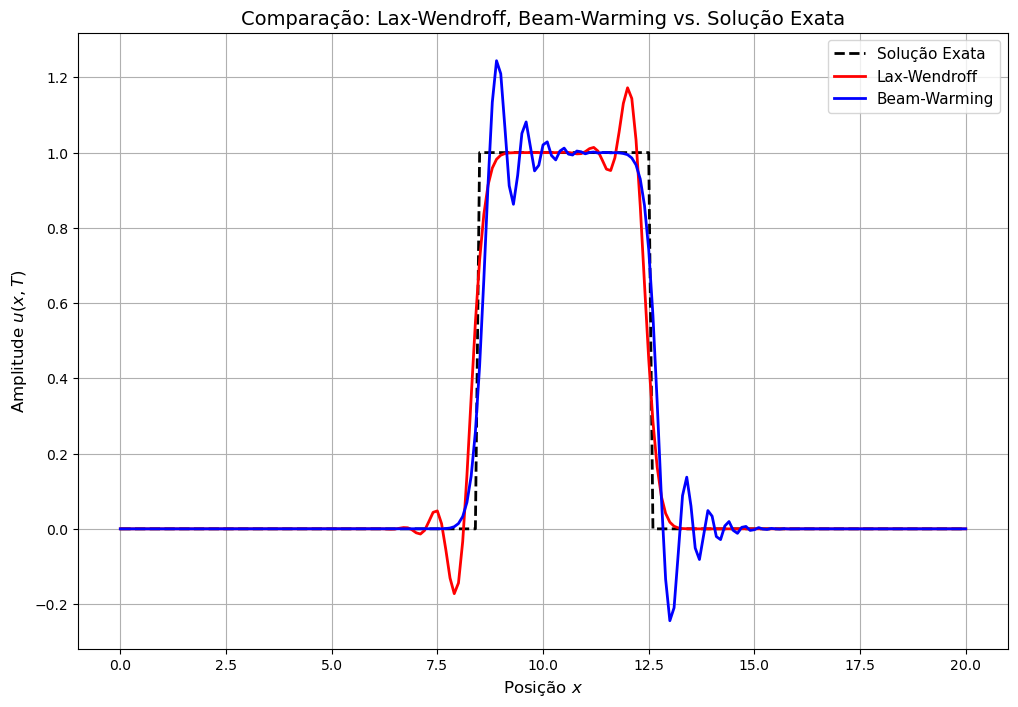

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parâmetros do Problema ---
L = 20.0  # Comprimento do domínio espacial
T = 15.0  # Tempo final
c = 0.5   # Coeficiente de advecção (velocidade)

''' Discretização da Malha '''
Nx = 201  # Número de pontos espaciais.
dx = L / (Nx - 1)

# Número de passos de tempo. Escolha para satisfazer a condição CFL
# Para Lax-Friedrichs, Lax-Wendroff, Upwind, CFL <= 1. Leapfrog requer CFL <= 1.
# Um valor seguro de CFL é em torno de 0.8
CFL_target = 0.8
dt = CFL_target * dx / abs(c)
Nt = int(T / dt) + 1
dt = T / Nt  # Ajusta dt para que o tempo final seja exato

# Malha espacial
x = np.linspace(0, L, Nx)

''' Condição Inicial '''
def initial_condition(x):
    '''
    Função que define a condição inicial.
    Retorna 1 para x em [1, 5] e 0 caso contrário.
    '''
    u0 = np.zeros_like(x)
    u0[(x >= 1) & (x <= 5)] = 1.0
    return u0

u_initial = initial_condition(x)

''' Solução Exata '''
def exact_solution(x, t, c, u_initial_func):
    '''
    Calcula a solução exata em um tempo t.
    '''
    # A solução exata é a condição inicial deslocada por c*t
    return u_initial_func(x - c * t)

u_exata = exact_solution(x, T, c, initial_condition)

''' Funções de Plotagem '''
def plot_solutions(x, solutions, title, exact_solution_data):
    '''
    Função genérica para plotar as soluções.
    solutions é um dicionário {nome_metodo: dados_solucao}.
    '''
    plt.figure(figsize=(12, 8))
    plt.plot(x, exact_solution_data, label='Solução Exata', color='black', linestyle='--', linewidth=2)
    
    colors = ['red', 'blue', 'green']
    for i, (name, data) in enumerate(solutions.items()):
        plt.plot(x, data, label=name, color=colors[i], linewidth=2)
        
    plt.title(title, fontsize=14)
    plt.xlabel('Posição $x$', fontsize=12)
    plt.ylabel('Amplitude $u(x, T)$', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=11)
    plt.show()

''' Implementação dos Métodos Numéricos '''

# a) Método Leapfrog
def solve_leapfrog(u_initial, Nx, Nt, dt, dx, c):
    u_prev = np.copy(u_initial)
    u_curr = np.zeros(Nx)
    alpha = c * dt / dx
    
    # Passo de inicialização usando Lax-Friedrichs para u^1
    u_curr[1:-1] = 0.5 * (u_prev[:-2] + u_prev[2:]) - 0.5 * alpha * (u_prev[2:] - u_prev[:-2])
    # Condições de contorno periódicas
    u_curr[0] = 0.5 * (u_prev[-2] + u_prev[1]) - 0.5 * alpha * (u_prev[1] - u_prev[-2])
    u_curr[-1] = u_curr[0]
    
    # Loop principal Leapfrog
    for n in range(1, Nt):
        u_next = np.zeros(Nx)
        u_next[1:-1] = u_prev[1:-1] - alpha * (u_curr[2:] - u_curr[:-2])
        # Condições de contorno periódicas
        u_next[0] = u_prev[0] - alpha * (u_curr[1] - u_curr[-2])
        u_next[-1] = u_next[0]
        
        u_prev = u_curr
        u_curr = u_next
    
    return u_curr

# b) Métodos Lax-Friedrichs e Upwind
def solve_lax_friedrichs(u_initial, Nx, Nt, dt, dx, c):
    u = np.copy(u_initial)
    alpha = c * dt / dx
    for n in range(Nt):
        u_new = np.zeros(Nx)
        u_new[1:-1] = 0.5 * (u[:-2] + u[2:]) - 0.5 * alpha * (u[2:] - u[:-2])
        # Condições de contorno periódicas
        u_new[0] = 0.5 * (u[-2] + u[1]) - 0.5 * alpha * (u[1] - u[-2])
        u_new[-1] = u_new[0]
        u = u_new
    return u

def solve_upwind(u_initial, Nx, Nt, dt, dx, c):
    u = np.copy(u_initial)
    alpha = c * dt / dx
    for n in range(Nt):
        u_new = np.zeros(Nx)
        # Para c > 0, usamos o esquema upwind (j-1, j)
        if c > 0:
            u_new[1:] = u[1:] - alpha * (u[1:] - u[:-1])
            u_new[0] = u[0] - alpha * (u[0] - u[-2]) # Condição de contorno periódica
        # Para c < 0, usaríamos o esquema (j, j+1)
        else:
            u_new[:-1] = u[:-1] - alpha * (u[1:] - u[:-1])
            u_new[-1] = u[-1] - alpha * (u[1] - u[-1])
            
        u = u_new
    return u

# c) Métodos Lax-Wendroff e Beam-Warming
def solve_lax_wendroff(u_initial, Nx, Nt, dt, dx, c):
    u = np.copy(u_initial)
    alpha = c * dt / dx
    for n in range(Nt):
        u_new = np.zeros(Nx)
        u_new[1:-1] = u[1:-1] - 0.5 * alpha * (u[2:] - u[:-2]) + 0.5 * alpha**2 * (u[2:] - 2*u[1:-1] + u[:-2])
        # Condições de contorno periódicas
        u_new[0] = u[0] - 0.5 * alpha * (u[1] - u[-2]) + 0.5 * alpha**2 * (u[1] - 2*u[0] + u[-2])
        u_new[-1] = u_new[0]
        u = u_new
    return u

def solve_beam_warming(u_initial, Nx, Nt, dt, dx, c):
    u = np.copy(u_initial)
    alpha = c * dt / dx
    for n in range(Nt):
        u_new = np.zeros(Nx)
        # Loop principal (necessita de j-2)
        u_new[2:] = u[2:] - alpha/2 * (3*u[2:] - 4*u[1:-1] + u[:-2]) + alpha**2/2 * (u[2:] - 2*u[1:-1] + u[:-2])
        # Condições de contorno periódicas (pontos 0 e 1)
        u_new[0] = u[0] - alpha/2 * (3*u[0] - 4*u[-2] + u[-3]) + alpha**2/2 * (u[0] - 2*u[-2] + u[-3])
        u_new[1] = u[1] - alpha/2 * (3*u[1] - 4*u[0] + u[-2]) + alpha**2/2 * (u[1] - 2*u[0] + u[-2])
        u_new[-1] = u_new[0]
        u = u_new
    return u

''' Resolução e Plotagem '''

# a) Resolvendo e plotando Leapfrog e comparando com a solução analítica
u_leapfrog = solve_leapfrog(u_initial, Nx, Nt, dt, dx, c)
solutions_a = {'Leapfrog': u_leapfrog}
plot_solutions(x, solutions_a, 'Comparação: Leapfrog vs. Solução Exata', u_exata)

# b) Resolvendo e plotando Lax-Friedrichs e Upwind no mesmo gráfico com a solução analítica
u_lf = solve_lax_friedrichs(u_initial, Nx, Nt, dt, dx, c)
u_upwind = solve_upwind(u_initial, Nx, Nt, dt, dx, c)
solutions_b = {'Lax-Friedrichs': u_lf, 'Upwind': u_upwind}
plot_solutions(x, solutions_b, 'Comparação: Lax-Friedrichs, Upwind vs. Solução Exata', u_exata)

# c) Resolvendo e plotando Lax-Wendroff e Beam-Warming no mesmo gráfico com a solução analítica
u_lw = solve_lax_wendroff(u_initial, Nx, Nt, dt, dx, c)
u_bw = solve_beam_warming(u_initial, Nx, Nt, dt, dx, c)
solutions_c = {'Lax-Wendroff': u_lw, 'Beam-Warming': u_bw}
plot_solutions(x, solutions_c, 'Comparação: Lax-Wendroff, Beam-Warming vs. Solução Exata', u_exata)

## Questão 2

Considere o seguinte problema de advecção-difusão
\begin{equation*}
\begin{cases}
    \displaystyle \frac{\partial u}{\partial t} + a\frac{\partial u}{\partial x} = 0.1\frac{\partial^2 u}{\partial x^2} \text{ em }\Omega \times I \\
    0.1 \nabla u \cdot \vec{n} = 0 \text{ em }\partial \Omega \times I \\
    u(x,0) = \begin{cases}
        1 & \text{ para } x\in[0.4,0.6]\\
        0 & \text{ c.c.}
    \end{cases}
\end{cases}
\end{equation*}
    
Tomando $\Omega = [0,1]$, $I=(0,1]$, $h_x=0.01$ e $h_t=0.0001$

a) Resolva este problema tomando a=0.2

b) Resolva este problema tomando a=-0.3

Resolvendo para a = 0.2:
  Número de CFL (Advecção): 0.0020
  Estabilidade (Difusão): 0.1000
Resolvendo para a = -0.3:
  Número de CFL (Advecção): -0.0030
  Estabilidade (Difusão): 0.1000


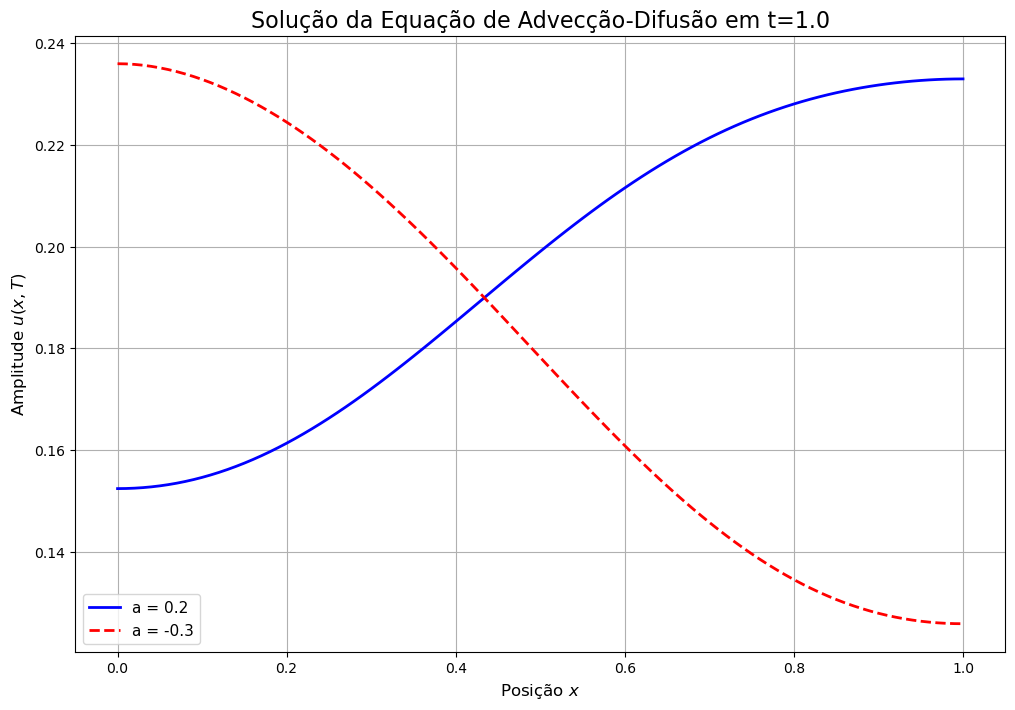

In [6]:
def solve_advection_diffusion(a, hx, ht, L, T):
    """
    Resolve a equação de advecção-difusão usando diferenças finitas explícitas.
    
    Args:
        a (float): Coeficiente de advecção.
        hx (float): Tamanho do passo espacial.
        ht (float): Tamanho do passo temporal.
        L (float): Comprimento do domínio espacial.
        T (float): Tempo final.
    """
    
    # Parâmetros do problema
    diffusivity = 0.1
    
    # Discretização
    Nx = int(L / hx) + 1
    Nt = int(T / ht) + 1
    
    # Malha espacial
    x = np.linspace(0, L, Nx)
    
    # Condição de estabilidade (CFL para advecção e difusão)
    # CFL de advecção: a * ht / hx <= 1
    # Estabilidade da difusão: diffusivity * ht / hx**2 <= 0.5
    # As condições de estabilidade combinadas podem ser mais restritivas.
    # O ht = 0.0001 dado atende a essas condições para os parâmetros a e hx.
    cfl_adv = a * ht / hx
    cfl_diff = diffusivity * ht / hx**2
    print(f"Resolvendo para a = {a}:")
    print(f"  Número de CFL (Advecção): {cfl_adv:.4f}")
    print(f"  Estabilidade (Difusão): {cfl_diff:.4f}")
    if cfl_diff > 0.5:
        print("  Condição de estabilidade de difusão violada.")
    
    # Coeficientes para a equação de atualização
    C1 = a * ht / (2 * hx)
    C2 = diffusivity * ht / hx**2
    
    # Condição inicial
    u = np.zeros(Nx)
    u[(x >= 0.4) & (x <= 0.6)] = 1.0
    
    # Solução para o passo anterior
    u_prev = np.copy(u)
    
    # Loop de tempo
    for n in range(Nt):
        u_new = np.zeros(Nx)
        
        # Atualiza os pontos internos (j=1 até Nx-2)
        u_new[1:-1] = (u_prev[1:-1] - C1 * (u_prev[2:] - u_prev[:-2]) + C2 * (u_prev[2:] - 2 * u_prev[1:-1] + u_prev[:-2]))
        
        # Condições de contorno de Neumann homogêneas (u_x = 0)
        # Borda esquerda (j=0): usa ponto fantasma u[-1] = u[1]
        u_new[0] = (u_prev[0] - C1 * (u_prev[1] - u_prev[1]) # u_1 - u_{-1} = u_1 - u_1 = 0
                    + C2 * (u_prev[1] - 2 * u_prev[0] + u_prev[1]))
        
        # Borda direita (j=Nx-1): usa ponto fantasma u[Nx] = u[Nx-2]
        u_new[-1] = (u_prev[-1]
                     - C1 * (u_prev[-2] - u_prev[-2]) # u_{N} - u_{N-2} = u_{N-2} - u_{N-2} = 0
                     + C2 * (u_prev[-2] - 2 * u_prev[-1] + u_prev[-2]))
        
        u_prev = u_new
        
    return x, u_new

''' Parâmetros do problema '''
L = 1.0
T = 1.0
hx = 0.01
ht = 0.0001

''' Resolução e Plotagem '''

# a) Resolvendo para a=0.2
x_a, u_a = solve_advection_diffusion(a=0.2, hx=hx, ht=ht, L=L, T=T)

# b) Resolvendo para a=-0.3
x_b, u_b = solve_advection_diffusion(a=-0.3, hx=hx, ht=ht, L=L, T=T)

# Plotagem dos resultados
plt.figure(figsize=(12, 8))
plt.plot(x_a, u_a, label=f'a = 0.2', color='blue', linewidth=2)
plt.plot(x_b, u_b, label=f'a = -0.3', color='red', linestyle='--', linewidth=2)

plt.title(f'Solução da Equação de Advecção-Difusão em t={T}', fontsize=16)
plt.xlabel('Posição $x$', fontsize=12)
plt.ylabel('Amplitude $u(x, T)$', fontsize=12)
plt.grid(True)
plt.legend(fontsize=11)
plt.show()